In [103]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder




validation_ids = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/validation_ids.csv')['participant_id'].tolist()
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d1 = d1.loc[~d1['participant_id'].isin(validation_ids)].reset_index(drop=True)
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d2 = d2.loc[~d2['participant_id'].isin(validation_ids)].reset_index(drop=True)
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
labels = labels.loc[~labels['participant_id'].isin(validation_ids)].reset_index(drop=True)
brain_probas = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/intermediate_output/adhd_probas')
df = d1.merge(d2, on='participant_id').merge(brain_probas, on='participant_id')#.merge(labels, on='participant_id')

df.head(10)
df['adhd_female'] = df['ADHD_Outcome']*df['Sex_F']


In [106]:
# limiting to only a few of the most salient features from EDA
keep_cols = ['participant_id', 
 'Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'MRI_Track_Scan_Location',
'APQ_P_APQ_P_CP',
'APQ_P_APQ_P_ID', 
'APQ_P_APQ_P_INV',
'APQ_P_APQ_P_OPD',
'APQ_P_APQ_P_PM', 
'APQ_P_APQ_P_PP',
'SDQ_SDQ_Conduct_Problems', 
'SDQ_SDQ_Difficulties_Total',
'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
'SDQ_SDQ_Generating_Impact', 
'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing',
         'SDQ_SDQ_Peer_Problems', 
         'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan',
         'ADHD_Outcome',
           'Sex_F', 
         'adhd_female'
         ]

#df.loc[:,keep_cols].groupby('ADHD_Outcome')['adhd_proba'].describe()

In [107]:

X_solutions = df.loc[:,keep_cols]

In [109]:
X_solutions[X_solutions['MRI_Track_Age_at_Scan'].isna()]['adhd_female'].value_counts()

adhd_female
0    242
1     66
Name: count, dtype: int64

In [110]:
X_solutions['Basic_Demos_Enroll_Year'] = X_solutions['Basic_Demos_Enroll_Year'].astype('str')
X_solutions['Basic_Demos_Study_Site'] = X_solutions['Basic_Demos_Study_Site'].astype('str')
X_solutions['MRI_Track_Scan_Location'] = X_solutions['MRI_Track_Scan_Location'].astype('str')
X_solutions['TF_MRI_Track_Age_at_Scan'] = pd.cut(X_solutions['MRI_Track_Age_at_Scan'], 4, labels=False).fillna('Missing')

In [111]:
X_solutions.groupby('TF_MRI_Track_Age_at_Scan')['adhd_female'].describe()

,count,mean,std,min,25%,50%,75%,max
TF_MRI_Track_Age_at_Scan,,,,,,,,
0.0,3.0,0.333333,0.577350,0.0,0.0,0.0,0.5,1.0
1.0,352.0,0.207386,0.406012,0.0,0.0,0.0,0.0,1.0
2.0,305.0,0.209836,0.407861,0.0,0.0,0.0,0.0,1.0
3.0,64.0,0.187500,0.393398,0.0,0.0,0.0,0.0,1.0
Missing,308.0,0.214286,0.410994,0.0,0.0,0.0,0.0,1.0


In [52]:
X_solutions.loc[X_solutions['TF_MRI_Track_Age_at_Scan']==0]

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,MRI_Track_Scan_Location,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,...,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F,TF_MRI_Track_Age_at_Scan
55,zSOTbT8r7FQ2,2016,1,0,3,17,47,19,14,30,...,12,6,10,5,3,7,0.000000,1,0,0.0
300,NHpNjWCsdA90,2016,1,2,0,0,0,0,0,0,...,6,3,3,0,0,10,5.360255,1,1,0.0
1014,x0yuhCZiG4mU,2016,1,0,3,12,46,13,15,27,...,2,0,1,0,0,9,0.000000,0,1,0.0


In [112]:
X_solutions.loc[X_solutions['TF_MRI_Track_Age_at_Scan']==0,'TF_MRI_Track_Age_at_Scan'] = 'Missing' # lumping in with Missing

In [113]:
X_solutions.groupby('TF_MRI_Track_Age_at_Scan')['Sex_F'].describe()

,count,mean,std,min,25%,50%,75%,max
TF_MRI_Track_Age_at_Scan,,,,,,,,
1.0,352.0,0.355114,0.479229,0.0,0.0,0.0,1.0,1.0
2.0,305.0,0.321311,0.467748,0.0,0.0,0.0,1.0,1.0
3.0,64.0,0.359375,0.483610,0.0,0.0,0.0,1.0,1.0
Missing,311.0,0.360129,0.480811,0.0,0.0,0.0,1.0,1.0


In [114]:
X_solutions.drop(['MRI_Track_Age_at_Scan'], axis=1, inplace=True)
X_solutions = pd.get_dummies(X_solutions, columns=['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site','MRI_Track_Scan_Location','TF_MRI_Track_Age_at_Scan'], drop_first=True).reset_index()

In [115]:
X_solutions.set_index('participant_id', inplace=True)

X = X_solutions.drop(['ADHD_Outcome', 'Sex_F','index','adhd_female'], axis=1)
y_adhd_outcome = X_solutions['ADHD_Outcome']
y_sex_f = X_solutions['Sex_F']
y_adhd_female = X_solutions['adhd_female']


In [57]:
X

,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,...,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,MRI_Track_Scan_Location_1,MRI_Track_Scan_Location_2,MRI_Track_Scan_Location_3,MRI_Track_Scan_Location_4,TF_MRI_Track_Age_at_Scan_2.0,TF_MRI_Track_Age_at_Scan_3.0,TF_MRI_Track_Age_at_Scan_Missing
participant_id,,,,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,3,10,47,13,11,28,0,6,1,5,...,False,False,False,True,False,False,False,False,False,True
CPaeQkhcjg7d,3,13,34,18,23,30,0,18,6,8,...,False,True,False,False,False,True,False,False,False,True
Nb4EetVPm3gs,4,10,35,16,10,29,1,14,2,8,...,False,False,False,True,False,False,False,False,False,False
p4vPhVu91o4b,5,12,39,19,16,28,6,24,4,16,...,False,True,False,False,False,True,False,False,False,True
M09PXs7arQ5E,5,15,40,20,24,28,1,18,4,11,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ZqEcqENo02n,3,10,45,13,14,28,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
8RqLpySUwmWx,3,6,49,21,14,30,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
Zusa1n9tQ3Yb,5,20,45,21,20,29,1,9,2,6,...,False,True,False,False,False,True,False,False,False,True


In [116]:
# Split once for multiple y variables
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y_adhd_outcome, y_adhd_female, test_size=0.15, random_state=42
)

In [161]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create an ensemble model using VotingClassifier (stacking)
ensemble_model= VotingClassifier(
    estimators=[('rf', rf_classifier), ('gb', gb_classifier)],
    voting='soft'  # 'hard' for majority class voting
)



# Train the ensemble model
ensemble_model.fit(X_train, y1_train) 

# Make predictions for the first target
y_pred= ensemble_model.predict_proba(X_test)
#print(f"Accuracy for target1 (classification): {accuracy_score(y1_test, y_pred):.4f}")


# #Train the ensemble model for the second target
# ensemble_model.fit(X_train, y2_train)  # Train for the second target (y_train2)
# y_pred_s = ensemble_model.predict_proba(X_test)
# #print(f"Accuracy for target2 (classification): {accuracy_score(y2_test, y_pred_s):.4f}")



In [162]:
feature_importances = {}
for model in ensemble_model.named_estimators_:
    clfr= ensemble_model.named_estimators_[model]
    importances = clfr.feature_importances_
    feature_importances[(model)] = importances

 
    

In [163]:
feature_names = X_train.columns
avg_importance = np.mean(list(feature_importances.values()), axis=0)
importance_dict = dict(zip(feature_names, avg_importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

SDQ_SDQ_Hyperactivity: 0.3313
SDQ_SDQ_Difficulties_Total: 0.0764
SDQ_SDQ_Generating_Impact: 0.0630
SDQ_SDQ_Externalizing: 0.0628
APQ_P_APQ_P_INV: 0.0479
APQ_P_APQ_P_PM: 0.0432
APQ_P_APQ_P_OPD: 0.0406
APQ_P_APQ_P_PP: 0.0375
APQ_P_APQ_P_ID: 0.0315
SDQ_SDQ_Internalizing: 0.0304
APQ_P_APQ_P_CP: 0.0283
SDQ_SDQ_Emotional_Problems: 0.0273
SDQ_SDQ_Prosocial: 0.0262
SDQ_SDQ_Conduct_Problems: 0.0228
SDQ_SDQ_Peer_Problems: 0.0222
Basic_Demos_Enroll_Year_2016: 0.0171
MRI_Track_Scan_Location_3: 0.0126
MRI_Track_Scan_Location_1: 0.0120
TF_MRI_Track_Age_at_Scan_3.0: 0.0103
TF_MRI_Track_Age_at_Scan_2.0: 0.0097
Basic_Demos_Enroll_Year_2017: 0.0093
Basic_Demos_Enroll_Year_2018: 0.0085
Basic_Demos_Study_Site_3: 0.0068
TF_MRI_Track_Age_at_Scan_Missing: 0.0063
Basic_Demos_Enroll_Year_2019: 0.0062
MRI_Track_Scan_Location_2: 0.0044
Basic_Demos_Study_Site_4: 0.0028
MRI_Track_Scan_Location_4: 0.0022
Basic_Demos_Study_Site_2: 0.0005
Basic_Demos_Enroll_Year_2020: 0.0000


In [167]:
test_df_adhd = pd.DataFrame(list(zip(y1_test,(y_pred[:,1]))), columns=['actual','predicted'])
test_df_adhd['adhd_female'] = y2_test.values

In [165]:
#test_df_adhd.loc[(test_df_adhd['adhd_female']==1)]['predicted']

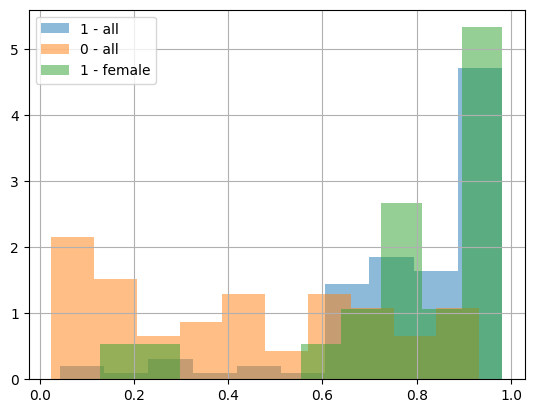

In [168]:
#pd.Series(y_pred[:,1]).hist()
#pd.Series(y_pred_s[:,1]).hist()

test_df_adhd.loc[test_df_adhd['actual']==1]['predicted'].hist(alpha=.5, label='1 - all', density=True)
test_df_adhd.loc[test_df_adhd['actual']==0]['predicted'].hist(alpha=.5, label='0 - all', density=True)
test_df_adhd.loc[(test_df_adhd['adhd_female']==1)]['predicted'].hist(alpha=.5, label='1 - female', density=True)

# test_df_sex.loc[test_df_sex['actual']==1]['predicted'].hist(alpha=.5, label='1', density=True)
# test_df_sex.loc[test_df_sex['actual']==0]['predicted'].hist(alpha=.5, label='0', density=True)

plt.legend()

In [169]:
from sklearn.metrics import precision_recall_curve, confusion_matrix,roc_curve, roc_auc_score
precision_vals, recall_vals, thresholds = precision_recall_curve(y1_test, y_pred[:,1])

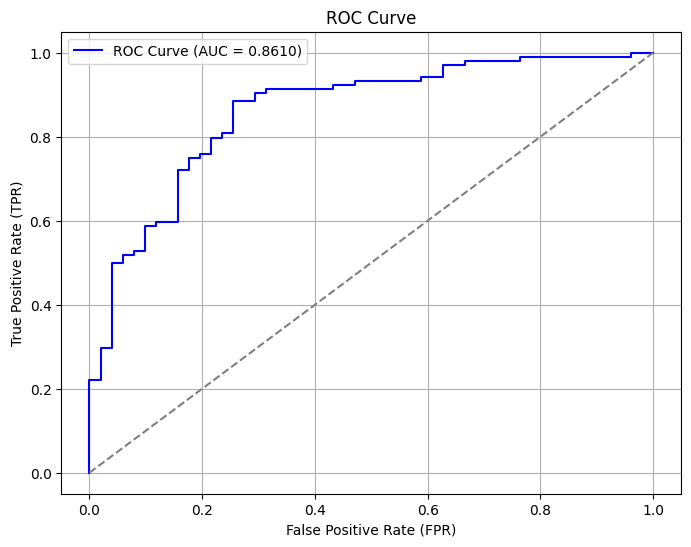

In [170]:
# Compute ROC curve and AUC score
fpr, tpr, roc_thresholds = roc_curve(y1_test, y_pred[:, 1])  # Assuming y_pred contains probabilities for class 1
auc_score = roc_auc_score(y1_test, y_pred[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()



In [171]:
# Compute Youden's J statistic to find the optimal threshold
j_scores = tpr - fpr  # Youden's J statistic
optimal_idx = j_scores.argmax()  # Index of max J score
optimal_threshold = roc_thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")

Optimal threshold: 0.6310


## Just Gender Prediction with a very small model

In [188]:
girl_cols = ['ColorVision_CV_Score','SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Hyperactivity','SDQ_SDQ_Internalizing',  'SDQ_SDQ_Prosocial','Sex_F','participant_id']

sex_df = df.loc[:,girl_cols]

In [189]:
sex_df

,ColorVision_CV_Score,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Prosocial,Sex_F,participant_id
0,13,1,5,5,1,10,1,UmrK0vMLopoR
1,14,6,8,8,10,5,0,CPaeQkhcjg7d
2,14,2,8,7,6,9,0,Nb4EetVPm3gs
3,10,4,16,10,8,6,1,p4vPhVu91o4b
4,14,4,11,10,7,9,1,M09PXs7arQ5E
...,...,...,...,...,...,...,...,...
1027,14,0,0,0,0,10,1,8ZqEcqENo02n
1028,14,0,0,0,0,10,0,8RqLpySUwmWx
1029,14,2,6,5,3,9,1,Zusa1n9tQ3Yb
1030,14,2,7,6,2,9,0,Atx7oub96GXS


In [190]:
sex_df.set_index('participant_id', inplace=True)

X = sex_df.drop(['Sex_F'], axis=1)
y_sex_f = sex_df['Sex_F']


In [191]:
# Split once for multiple y variables
X_train, X_test, y1_train, y1_test = train_test_split(
    X, y_adhd_female, test_size=0.15, random_state=42
)

In [199]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create an ensemble model using VotingClassifier (stacking)
ensemble_model= VotingClassifier(
    estimators=[('rf', rf_classifier), ('gb', gb_classifier)],
    voting='soft'  # 'hard' for majority class voting
)



# Train the ensemble model
ensemble_model.fit(X_train, y1_train) 
y_pred= ensemble_model.predict(X_test)
print(f"Accuracy for target1 (classification): {accuracy_score(y1_test, y_pred):.4f}")


Accuracy for target1 (classification): 0.8452


In [208]:
y1_train.sum()/y1_train.count()

0.22120866590649943

In [193]:
feature_importances = {}
for model in ensemble_model.named_estimators_:
    clfr= ensemble_model.named_estimators_[model]
    importances = clfr.feature_importances_
    feature_importances[(model)] = importances

 
    

In [194]:
feature_names = X_train.columns
avg_importance = np.mean(list(feature_importances.values()), axis=0)
importance_dict = dict(zip(feature_names, avg_importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

SDQ_SDQ_Internalizing: 0.2137
SDQ_SDQ_Hyperactivity: 0.2118
SDQ_SDQ_Prosocial: 0.1748
SDQ_SDQ_Externalizing: 0.1746
SDQ_SDQ_Emotional_Problems: 0.1450
ColorVision_CV_Score: 0.0800


In [195]:
test_df_female = pd.DataFrame(list(zip(y1_test,(y_pred[:,1]))), columns=['actual','predicted'])

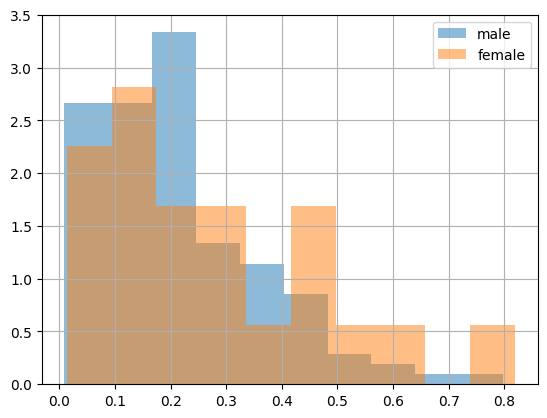

In [198]:
test_df_female[test_df_female['actual']==0]['predicted'].hist(alpha=.5, label='male',density=True)
test_df_female[test_df_female['actual']==1]['predicted'].hist(alpha=.5, label='female',density=True)

plt.legend();

In [204]:
conf_matrix = confusion_matrix(y1_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[128   5]
 [ 19   3]]


In [ ]:
# submission = pd.DataFrame({
#     'participant_id': test_connectome.index,
#     'ADHD_Outcome': final_pred1,
#     'Sex_F': final_pred2,
# })

# submission['ADHD_Outcome'] = submission['ADHD_Outcome'].astype(int)
# submission['Sex_F'] = submission['Sex_F'].astype(int)

# submission.to_csv('submission.csv', index=False)